# Neural Network for banknote detection:

Importing libraries:

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

Loading the data:


In [2]:
data_path='/content/drive/MyDrive/NAML/Project/data_banknote_authentication.txt'
data_np=np.loadtxt(data_path, delimiter=',')

In [3]:
x_data = data_np[:,0:4]
y_data = data_np[:,-1]
print(x_data.shape, "\n")
print(y_data.shape, "\n")

(1372, 4) 

(1372,) 



# Data Exploration

The dataset contains some features extracted from the images of some banknotes and their classification. Data were extracted from images taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x400 pixels. Due to the object lens and to the distance from the investigated object, gray-scale pictures with a resolution of about 660 dpi were obtained. Wavelet Transform tool were used to extract features from the images.
The matrix x_data contains a sample (in our case a banknote) for each row and a feature for each columns, in particular:

1.   The first column contains the variance of Wavelet Transformed image.
2.   The second contains the skewness of Wavelet Transformed image.
3.   The third contains the curtosis (a measure of the "tailedness" of the probability distribution of a real-valued random variable) of Wavelet Transformed image.
4.   The fourth contains the entropy of the image.

The vector y_data contains the classification of the samples (1 if the banknote is genuine, 0 if it is forged).





Now let's do some exploration on the dataset:

In [4]:
data = pd.DataFrame(x_data, columns = ['variance','skewness','curtosis','entropy'])
data.head()

,variance,skewness,curtosis,entropy
0,3.62160,8.6661,-2.8073,-0.44699
1,4.54590,8.1674,-2.4586,-1.46210
2,3.86600,-2.6383,1.9242,0.10645
3,3.45660,9.5228,-4.0112,-3.59440
4,0.32924,-4.4552,4.5718,-0.98880


In [5]:
data.describe()

,variance,skewness,curtosis,entropy
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


In [6]:
data.corr()

,variance,skewness,curtosis,entropy
variance,1.000000,0.264026,-0.380850,0.276817
skewness,0.264026,1.000000,-0.786895,-0.526321
curtosis,-0.380850,-0.786895,1.000000,0.318841
entropy,0.276817,-0.526321,0.318841,1.000000


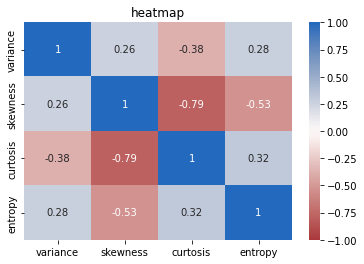

In [7]:
ax = plt.axes()
sns.heatmap(data.corr(), annot = True, cmap = 'vlag_r', vmin = -1, vmax = 1)
ax.set_title('heatmap')
plt.show()

Text(0.5, 1.08, 'Pairplot')

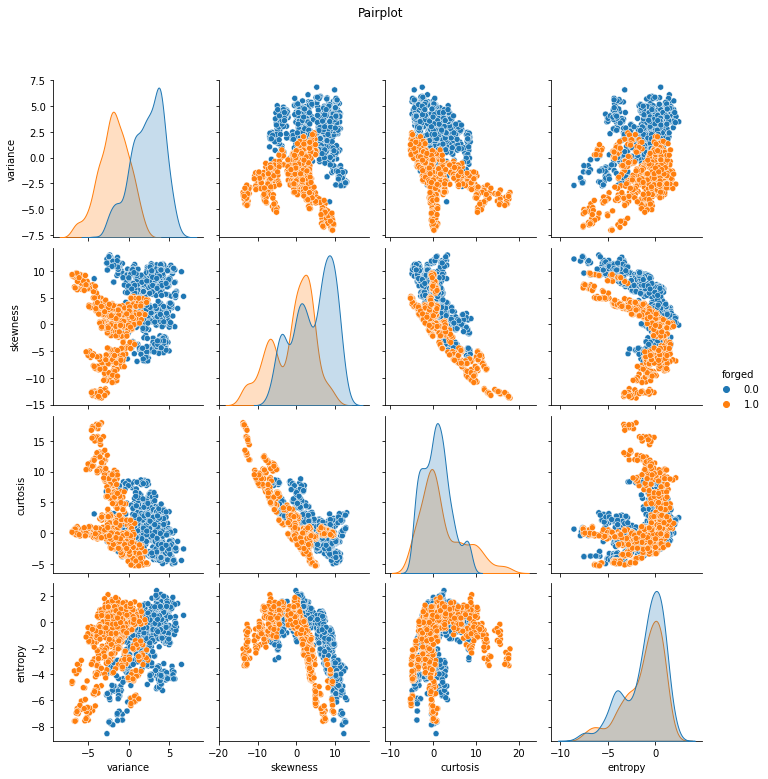

In [8]:
data_with_labels = pd.DataFrame(data_np, columns = ['variance','skewness','curtosis','entropy', 'forged'])
g=sns.pairplot (data_with_labels, hue='forged')
g.fig.suptitle("Pairplot",y=1.08) # y= some height>1

Text(0.5, 1.0, 'violin plot')

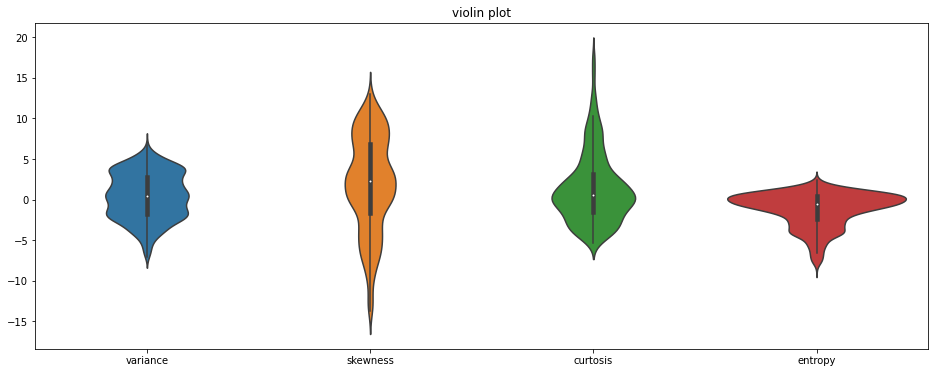

In [9]:
_, ax = plt.subplots(figsize=(16,6))
sns.violinplot(data = data, ax = ax)
ax.set_title('violin plot')

From the description of the dataset and the violins plots it can be noticed that these features have different ranges and variance: this could be an indication about the necessity to normalize the data.

In [10]:
data_mean = data.mean()
data_std = data.std()
data_normalized = (data - data_mean) / data_std

Text(0.5, 1.0, 'violin plot (normalized variables)')

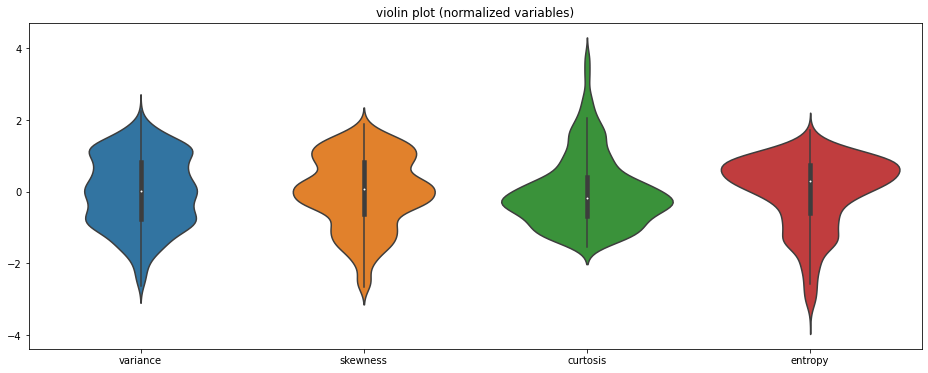

In [11]:
_, ax = plt.subplots(figsize=(16,6))
sns.violinplot(data = data_normalized, ax = ax)
ax.set_title('violin plot (normalized variables)')

# Principal component analysis

In [12]:
A=x_data.transpose()
A_mean=np.mean(A, axis=1)
A_mean.shape

(4,)

Text(0.5, 0.98, 'Singular values')

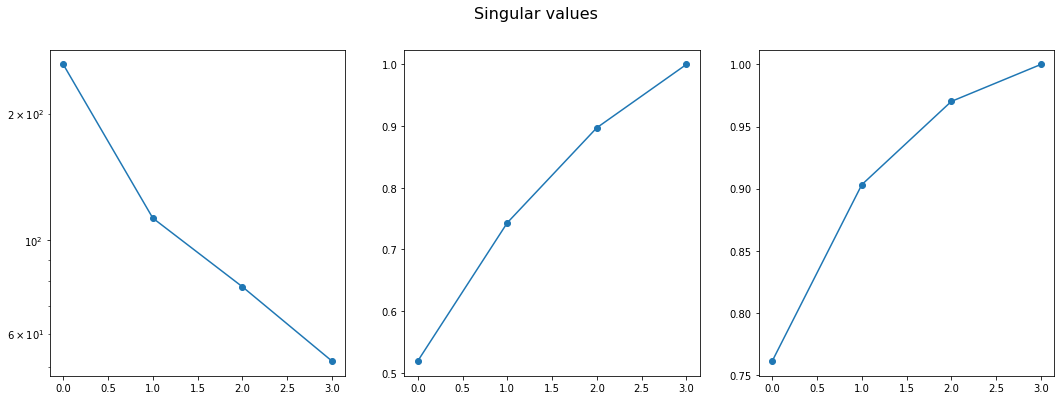

In [13]:
U, s, VT=np.linalg.svd(A-A_mean[:, None], full_matrices='False')
fig, axs=plt.subplots(nrows=1, ncols=3, figsize=(18,6))
axs[0].semilogy(s, '-o')
axs[1].plot(np.cumsum(s)/np.sum(s), '-o')
axs[2].plot(np.cumsum(s**2)/np.sum(s**2), '-o')
fig.suptitle('Singular values', fontsize=16)

Text(0.5, 1.0, 'First 2 principal components')

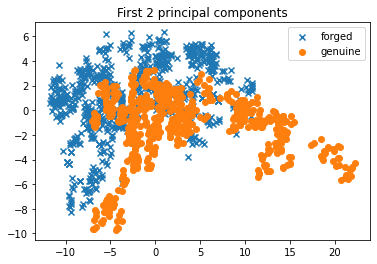

In [14]:
indexes_false=(data_np[:, -1]==1)
indexes_true=(data_np[:, -1]==0)
Phi=np.matmul(U.transpose(), A-A_mean[:, None] )
plt.scatter(Phi[0, indexes_true], Phi[1, indexes_true], marker='x', label='forged')
plt.scatter(Phi[0, indexes_false], Phi[1, indexes_false], marker='o', label='genuine')
plt.legend()
plt.title('First 2 principal components')

# Train-validation split

Let's first split our dataset in training and validation set (about 2/3 of the samples for the training and 1/3 for the validation).

In [15]:
np.random.seed(26)

# ensure all data are floating point values
np.random.shuffle(data_np)
x_data=data_np[:, 0:4]
y_data=data_np[:, -1]
y_data = LabelEncoder().fit_transform(y_data)
x_data_mean = x_data.mean()
x_data_std = x_data.std()
x_data_normalized = (x_data - x_data_mean) / x_data_std    #did we really need normalization??
n_train=915
n_valid=457
x_train = x_data[:n_train ,:]
y_train = y_data[:n_train]                                 #if you don't want normalization
x_valid = x_data[-n_valid:,:]
y_valid = y_data[-n_valid:]
#x_train = x_data_normalized[:n_train ,:]
#y_train = y_data[:n_train]                                 #if you want normalization
#x_valid = x_data_normalized[-n_valid:,:]
#y_valid = y_data[-n_valid:]

train_ptg=100*y_train.shape[0]/y_data.shape[0]
validation_ptg=100*y_valid.shape[0]/y_data.shape[0]


print("Training set: %.2f" % train_ptg, "%")
print("Validation set: %.2f" % validation_ptg, "%")



Training set: 66.69 %
Validation set: 33.31 %


# ANN setup and training

We create a fully connected ANN, with one hidden layer of 10 neurons and Relu as activation function, and a sigmoid layer for the output.

In [16]:
model_1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),


    keras.layers.Dense(1, activation='sigmoid'),
])

We compile the model (that is, we trace the computational graph by Autograph). We use Adam as optimizer (that can infer by himself the learning rate) and binary cross entropy as loss function.

In [17]:
model_1.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Training:

In [18]:
history=model_1.fit(x_train, y_train, epochs = 50, validation_data = (x_valid, y_valid), batch_size=32)

Epoch 1/50
29/29 [==============================] - 2s 23ms/step - loss: 1.6801 - accuracy: 0.5781 - val_loss: 1.3103 - val_accuracy: 0.6149
Epoch 2/50
29/29 [==============================] - 0s 3ms/step - loss: 1.3210 - accuracy: 0.6186 - val_loss: 1.0661 - val_accuracy: 0.6433
Epoch 3/50
29/29 [==============================] - 0s 3ms/step - loss: 1.0370 - accuracy: 0.6393 - val_loss: 0.8675 - val_accuracy: 0.6718
Epoch 4/50
29/29 [==============================] - 0s 3ms/step - loss: 0.8145 - accuracy: 0.6656 - val_loss: 0.7089 - val_accuracy: 0.6915
Epoch 5/50
29/29 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.7071 - val_loss: 0.5831 - val_accuracy: 0.7068
Epoch 6/50
29/29 [==============================] - 0s 3ms/step - loss: 0.5277 - accuracy: 0.7410 - val_loss: 0.4996 - val_accuracy: 0.7527
Epoch 7/50
29/29 [==============================] - 0s 3ms/step - loss: 0.4544 - accuracy: 0.7836 - val_loss: 0.4427 - val_accuracy: 0.7856
Epoch 8/50
29/29 [=

Text(0.5, 0, 'Epochs')

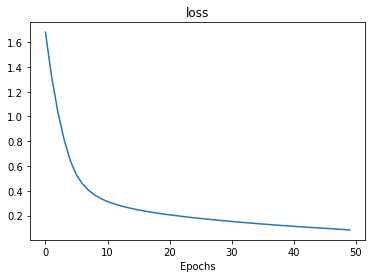

In [19]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

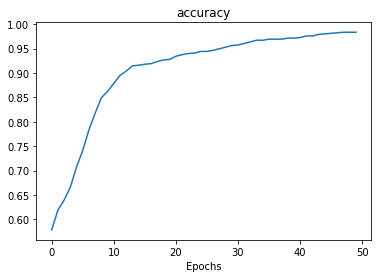

In [20]:
plt.plot(history.history['accuracy'])
plt.title('accuracy')
plt.xlabel('Epochs')

In [21]:
labels = model_1.predict(x_valid)
labels[labels>=0.5]=1
labels[labels<0.5]=0
y_predicted=labels.astype(int)
y_predicted=y_predicted.flatten()
# evaluate predictions
score = tf.reduce_mean(tf.cast(y_predicted == y_valid, tf.float32))
print('Accuracy on validation: %.3f' % score)

Accuracy on validation: 0.978


As we can see, we obtain quite good results (almost 100% accuracy both on validation and training set, depending on the seed) even using a very simple and computationally cheap neural network. If we slightly increase the dimensions of the neural network (using for example two hidden layer of 25 neurons each) it seems that we are able to achieve always 100% accuracy both on the training and validation set:

In [22]:
model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(25, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(25, activation='relu', kernel_initializer='he_normal'),


    keras.layers.Dense(1, activation='sigmoid'),
])

In [23]:
model_2.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [24]:
history=model_2.fit(x_train, y_train, epochs = 50, validation_data = (x_valid, y_valid), batch_size=32)

Epoch 1/50
29/29 [==============================] - 2s 23ms/step - loss: 1.7401 - accuracy: 0.4612 - val_loss: 0.5954 - val_accuracy: 0.6302
Epoch 2/50
29/29 [==============================] - 0s 9ms/step - loss: 0.3535 - accuracy: 0.8503 - val_loss: 0.2440 - val_accuracy: 0.9540
Epoch 3/50
29/29 [==============================] - 0s 10ms/step - loss: 0.1588 - accuracy: 0.9923 - val_loss: 0.1344 - val_accuracy: 0.9978
Epoch 4/50
29/29 [==============================] - 0s 6ms/step - loss: 0.1033 - accuracy: 0.9978 - val_loss: 0.0964 - val_accuracy: 0.9978
Epoch 5/50
29/29 [==============================] - 0s 10ms/step - loss: 0.0764 - accuracy: 0.9978 - val_loss: 0.0758 - val_accuracy: 0.9978
Epoch 6/50
29/29 [==============================] - 0s 8ms/step - loss: 0.0604 - accuracy: 0.9989 - val_loss: 0.0612 - val_accuracy: 0.9978
Epoch 7/50
29/29 [==============================] - 0s 10ms/step - loss: 0.0496 - accuracy: 0.9989 - val_loss: 0.0518 - val_accuracy: 0.9978
Epoch 8/50
29/29

Text(0.5, 0, 'Epochs')

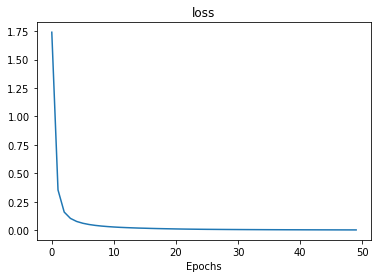

In [25]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

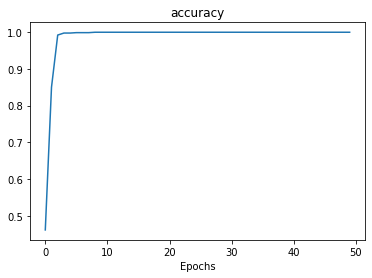

In [26]:
plt.plot(history.history['accuracy'])
plt.title('accuracy')
plt.xlabel('Epochs')

In [27]:
labels = model_2.predict(x_valid)
labels[labels>=0.5]=1
labels[labels<0.5]=0
y_predicted=labels.astype(int)
y_predicted=y_predicted.flatten()
# evaluate predictions
score = tf.reduce_mean(tf.cast(y_predicted == y_valid, tf.float32))
print('Validation accuracy: %.3f' % score)

Validation accuracy: 1.000


As previously said, in this case we obtain 100% accuracy both on the validation and training set and, as we can see from the plots, we need only few epochs to achieve these results.

# Cross validation

To have a more robust model evaluation, we can use a k-fold cross validation. Usually, this procedure takes time because it is very expensive, but in our case, since the dataset is small and we have a small number of features, we can use it to confirm the goodness of our model.

First let's perform k-fold crossvalidation on the cheapest neural network:

In [ ]:
kfold = StratifiedKFold(10)
scores = list()
for train_ix, test_ix in kfold.split(x_data, y_data):
  x_train = x_data[train_ix ,:]
  y_train = y_data[train_ix]
  x_valid = x_data[test_ix,:]
  y_valid = y_data[test_ix]
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),


    keras.layers.Dense(1, activation='sigmoid'),
  ])
  model.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
  model.fit(x_train, y_train, epochs = 50, batch_size=32)
  labels = model.predict(x_valid)
  labels[labels>=0.5]=1
  labels[labels<0.5]=0
  y_predicted=labels.astype(int)
  y_predicted=y_predicted.flatten()
  # evaluate predictions
  score = tf.reduce_mean(tf.cast(y_predicted == y_valid, tf.float32))
  scores.append(score)
 




In [29]:
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores))) 

Mean Accuracy: 0.998 (0.005)


Using this simple model, we already obtain a remarkable cross validation accuracy (almost 100%, with little variations depending on the seed).

In [ ]:
kfold = StratifiedKFold(10)
scores = list()
for train_ix, test_ix in kfold.split(x_data, y_data):
  x_train = x_data[train_ix ,:]
  y_train = y_data[train_ix]
  x_valid = x_data[test_ix,:]
  y_valid = y_data[test_ix]
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(25, activation='tanh'),
    keras.layers.Dense(25, activation='tanh'),



    keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal'),
    
  ]) 
  model.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
  model.fit(x_train, y_train, epochs = 50, batch_size=32)
  labels = model.predict(x_valid)
  labels[labels>=0.5]=1
  labels[labels<0.5]=0
  y_predicted=labels.astype(int)
  y_predicted=y_predicted.flatten()
  # evaluate predictions
  score = tf.reduce_mean(tf.cast(y_predicted == y_valid, tf.float32))
  scores.append(score)
  #print(train_ix)


In [31]:
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores))) 

Mean Accuracy: 1.000 (0.000)


Using the deeper neural network, we are able to achieve consistently 100% accuracy even with crossvalidation evaluation.

This confirms that the "base" model configuration works well for this dataset, and that the model is a good fit for this problem.
This is quite surprising since, from the data visualization, it would be reasonable to expect some data scaling to be required, but as we obtained very high accuracy without normalization, it seems that it is not needed in this case.

# Real scenario simulation

So far, we have split the dataset into training set and validation set because of the way the neural network was built (the validation set was what is usually called test set). Indeed, we are using the validation set only to evaluate the model and not to avoid to overfit the data, as for example we do when we use 'EarlyStopping'. Let's now imagine that our dataset is given by a client. Usually, the client would avoid to give us all the data in order to test our result. Imagining this situation, let's split again the dataset into training, validation and test set (which in this case are the samples that the clients keeps for himself, and that we cannot use by any means to construct our model).

In [32]:
np.random.seed(26)
n_train=686
n_valid=343
n_test=343

# ensure all data are floating point values
np.random.shuffle(data_np)
x_data=data_np[:, 0:4]
y_data=data_np[:, -1]
y_data = LabelEncoder().fit_transform(y_data)
x_data_mean = x_data.mean()
x_data_std = x_data.std()
x_data_normalized = (x_data - x_data_mean) / x_data_std    #did we really need normalization??
x_train = x_data[:n_train ,:]
y_train = y_data[:n_train]                                 #if you don't want normalization
x_valid = x_data[n_train:n_train+n_valid:,:]
y_valid = y_data[n_train:n_train+n_valid:]
x_test=x_data[-n_test:,:]
y_test = y_data[-n_test:]
#x_train = x_data_normalized[:n_train ,:]
#y_train = y_data[:n_train]                                 #if you want normalization
#x_valid = x_data_normalized[-n_valid:,:]
#y_valid = y_data[-n_valid:]

train_ptg=100*y_train.shape[0]/y_data.shape[0]
validation_ptg=100*y_valid.shape[0]/y_data.shape[0]
test_ptg=100*y_test.shape[0]/y_data.shape[0]

print("Training set: %.2f" % train_ptg, "%")
print("Validation set: %.2f" % validation_ptg, "%")
print("Test set: %.2f" % test_ptg, "%")


Training set: 50.00 %
Validation set: 25.00 %
Test set: 25.00 %


Let's now use the "deep" Neural Network (with 2 hidden layers of 20 neurons each).

In [33]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(20, activation='tanh'),
    keras.layers.Dense(20, activation='tanh'),


    keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal'),
]) 

In [34]:
model.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [35]:
history=model.fit(x_train, y_train, epochs = 50, validation_data = (x_valid, y_valid), batch_size=32)

Epoch 1/50
22/22 [==============================] - 1s 10ms/step - loss: 0.7419 - accuracy: 0.5437 - val_loss: 0.6189 - val_accuracy: 0.5977
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 0.5290 - accuracy: 0.7143 - val_loss: 0.4515 - val_accuracy: 0.8222
Epoch 3/50
22/22 [==============================] - 0s 5ms/step - loss: 0.3852 - accuracy: 0.8863 - val_loss: 0.3362 - val_accuracy: 0.9038
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2841 - accuracy: 0.9359 - val_loss: 0.2525 - val_accuracy: 0.9388
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.2122 - accuracy: 0.9606 - val_loss: 0.1937 - val_accuracy: 0.9621
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.1611 - accuracy: 0.9723 - val_loss: 0.1527 - val_accuracy: 0.9679
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.1262 - accuracy: 0.9781 - val_loss: 0.1229 - val_accuracy: 0.9767
Epoch 8/50
22/22 [=

From this output we can already see that, even with less data, we can obtain 100% accuracy on the validation.
Let's now see if we have good results even on the test set (that are samples that we have not "touched" yet).

In [36]:
labels = model.predict(x_test)
labels[labels>=0.6]=1
labels[labels<0.6]=0
y_predicted=labels.astype(int)
y_predicted=y_predicted.flatten()
# evaluate predictions
score = tf.reduce_mean(tf.cast(y_predicted == y_test, tf.float32))
print('Accuracy: %.3f' % score)

Accuracy: 1.000


We achieve 100% accuracy even on the test set, so in this case the client would be convinced that we did a good job.

# Conclusions

We see that we were able to train an artificial neural nerwork capaple to correctly classify almost all samples in the validation set even with a small number of neurons and with only one hidden layer. If we use a deeper network we are able to correctly classify all the samples (training, validation and test set in the real case scenario). Those results are confirmed even by a more robust evaluation method like k-fold crossvalidation. 